# AlexNet with images cropped according to the predicted bounding boxes as input

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import tensorflow as tf
from lib.Plot import plot
import matplotlib.pyplot as plt

In [4]:
all_ann = pd.read_csv("lib/datasets/LISA/allAnnotations.csv", delimiter=';')
#alex_b = tf.keras.models.load_model('App/lib/models/alex_bb')
all_ann

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,"Occluded,On another road",Origin file,Origin frame number,Origin track,Origin track frame number
0,aiua120214-0/frameAnnotations-DataLog02142012_...,stop,862,104,916,158,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2667,stop_1330545910.avi,2
1,aiua120214-0/frameAnnotations-DataLog02142012_...,speedLimitUrdbl,425,197,438,213,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2667,stop_1330545910.avi,2
2,aiua120214-0/frameAnnotations-DataLog02142012_...,stop,922,88,982,148,"1,0",aiua120214-0/DataLog02142012_external_camera.avi,2672,stop_1330545910.avi,7
3,aiua120214-0/frameAnnotations-DataLog02142012_...,speedLimit25,447,193,461,210,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2672,stop_1330545910.avi,7
4,aiua120214-0/frameAnnotations-DataLog02142012_...,speedLimit25,469,189,483,207,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2677,stop_1330545910.avi,12
...,...,...,...,...,...,...,...,...,...,...,...
7850,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,41,209,65,239,"0,0",vid9/MVI_0121.MOV,8813,speedLimit_1324866802.avi,22
7851,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,526,213,543,233,"0,0",vid9/MVI_0121.MOV,8875,speedLimit_1324866807.avi,2
7852,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,546,208,564,230,"0,0",vid9/MVI_0121.MOV,8880,speedLimit_1324866807.avi,7
7853,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,573,204,592,228,"0,0",vid9/MVI_0121.MOV,8885,speedLimit_1324866807.avi,12


In [22]:
from IPython.display import display
height = 224
width = 224
i=500
X_mean = []
y_mean = []
path = "lib/datasets/LISA/"
file = Adata["Filename"][i]
sign = Adata["Annotation tag"][i]
bb = (float(Adata['Upper left corner X'][i]),float(Adata['Upper left corner Y'][i]),float(Adata['Lower right corner X'][i]),float(Adata['Lower right corner Y'][i]))
image = Image.open(path+file)
shape_image = np.asarray(image).shape
bb_test = (bb[0]*224 / shape_image[1], bb[1]*224 / shape_image[0], bb[2]*224 /shape_image[1], bb[3]*224 / shape_image[0])
print(bb)
print(bb_test)
print(np.asarray(image).shape)
tmp = image.resize((width,height))
# display(tmp)


(17.0, 14.0, 115.0, 133.0)
(3.71875, 6.007662835249042, 25.15625, 57.0727969348659)
(522, 1024, 3)


In [8]:
height = 224
width = 224
X_mean = []
y_mean = []
path = "lib/datasets/LISA/"
for i in range(len(all_ann["Filename"])):
    file = all_ann["Filename"][i]
    bb = (float(all_ann['Upper left corner X'][i]),float(all_ann['Upper left corner Y'][i]),float(all_ann['Lower right corner X'][i]),float(all_ann['Lower right corner Y'][i])) 
    image = Image.open(path+file)
    shape_image = np.asarray(image).shape
    tmp = (bb[0]*224 / shape_image[1], bb[1]*224 / shape_image[0], bb[2]*224 /shape_image[1], bb[3]*224 / shape_image[0])
    X_mean.append(tmp[2] - tmp[0])
    y_mean.append(tmp[3] - tmp[1])

print(np.mean(X_mean), np.mean(y_mean))

9.101210144088883 16.37875750857862


In [15]:
def one_hot(lab, vals):
    hot = []
    for i in range(len(vals)):
        hot.append(lab.index(vals[i]))
    return hot

In [28]:
height = 224
width = 224
data = []
labels = []
boxes = []
path = "lib/datasets/LISA/"
test = 0
import random
sub_sample = random.sample(list(range(len(all_ann["Filename"]))), k=len(all_ann["Filename"])-2000) # The data set is too big for my PC
for i in sub_sample:
    file = all_ann["Filename"][i]
    sign = all_ann["Annotation tag"][i]
    bb = (float(all_ann['Upper left corner X'][i]),float(all_ann['Upper left corner Y'][i]),float(all_ann['Lower right corner X'][i]),float(all_ann['Lower right corner Y'][i])) 
    image = Image.open(path+file)
    shape_image = np.asarray(image).shape
    image = image.resize((width,height))
    image = np.asarray(image)
    data.append(image)
    labels.append(sign)
    boxes.append((bb[0]*224 / shape_image[1], bb[1]*224 / shape_image[0], bb[2]*224 /shape_image[1], bb[3]*224 / shape_image[0]))

signs = np.array(data)
labels = np.array(labels)
boxes = np.array(boxes)

# Randomize order
s = np.arange(signs.shape[0])
np.random.seed(43)
np.random.shuffle(s)
signs = signs[s]
labels = labels[s]
boxes = boxes[s]

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import  RandomOverSampler
split = train_test_split(signs, labels, boxes, test_size=0.25, random_state=1)
del signs
(X_train, X_test) = split[:2]
(y_train, y_test) = split[2:4]
(z_train, z_test) = split[4:]

X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

X_test /= 255.0
X_train /= 255.0

lab = all_ann["Annotation tag"].unique().tolist()
y_train = np.array(one_hot(lab,y_train))
y_test = np.array(one_hot(lab,y_test))

tmp = pd.DataFrame()
tmp["Label"] = lab
tmp["Encoding"] = list(range(len(lab)))

tmp.to_csv("lib/datasets/bbkey.csv", index=False)

np.save("lib/datasets/X_train.npy", X_train)
np.save("lib/datasets/X_test.npy", X_test)
np.save("lib/datasets/y_train.npy", y_train)
np.save("lib/datasets/y_test.npy", y_test)
np.save("lib/datasets/z_train.npy", z_train)
np.save("lib/datasets/z_test.npy", z_test)

In [3]:
X_train = np.load("lib/datasets/X_train.npy")
X_test = np.load("lib/datasets/X_test.npy")
y_train = np.load("lib/datasets/y_train.npy")
y_test = np.load("lib/datasets/y_test.npy")
z_train = np.load("lib/datasets/z_train.npy")
z_test = np.load("lib/datasets/z_test.npy")

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import tensorflow as tf
from lib.Plot import plot
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from receptivefield.keras import KerasReceptiveField
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, ZeroPadding2D, BatchNormalization, Input, InputLayer, AvgPool2D

In [2]:
all_ann = pd.read_csv("lib/datasets/LISA/allAnnotations.csv", delimiter=';')
height = 224
width = 224
i=500
path = "lib/datasets/LISA/"
file = all_ann["Filename"][i]
image = Image.open(path+file)
image = image.resize((width,height))
# image = np.asarray(image)

In [ ]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dropout(rate=0.5))
model.add(Dense(units=4096,activation="relu"))
model.add(Dropout(rate=0.5))
model.add(Dense(units=48, activation="softmax"))

In [2]:
def alex1(input_shape):
    alex_in = Input(shape=input_shape, name='input_image')
    alex = Conv2D(filters=64,kernel_size=(3,3),activation='linear',padding='valid', name='cv2')(alex_in)
    alex = Conv2D(filters=64,kernel_size=(3,3),activation='linear',padding='same', name='cv3')(alex)
    alex = AvgPool2D(pool_size=(2,2),strides=(2,2))(alex)
    alex = Conv2D(filters=128, kernel_size=(3,3),activation='linear',padding='same', name='cv4')(alex)
    alex = Conv2D(filters=128, kernel_size=(3,3),activation='linear',padding='same', name='cv5')(alex)
    alex = AvgPool2D((2,2),strides=2)(alex)
    alex = Conv2D(filters=256, kernel_size=(3,3),activation='linear',padding='same', name='cv6')(alex)
    alex = Conv2D(filters=256, kernel_size=(3,3),activation='linear',padding='same', name='cv7')(alex)
    alex = Conv2D(256,(5,5),activation='linear',padding='same', name='cv8')(alex)
    alex = AvgPool2D((2,2),strides=2)(alex)
    alex = Conv2D(filters=512, kernel_size=(3,3),activation='linear',padding='same', name='cv9')(alex)
    alex = Conv2D(filters=512, kernel_size=(3,3),activation='linear',padding='same', name='cv10')(alex)
    alex = Conv2D(filters=512, kernel_size=(3,3),activation='linear',padding='same', name='cv11')(alex)
    alex = AvgPool2D((3,3),strides=2)(alex)
    alex = Conv2D(filters=512, kernel_size=(3,3),activation='linear',padding='same', name='cv12')(alex)
    alex = Conv2D(filters=512, kernel_size=(3,3),activation='linear',padding='same', name='cv13')(alex)
    alex = Conv2D(filters=512, kernel_size=(3,3),activation='linear',padding='same', name='cv14')(alex)
    alex_out = AvgPool2D((3,3),strides=2)(alex)
    
#     alex = AvgPool2D((3,3),strides=2)(alex)
#     #alex = BatchNormalization()(alex)

#     #alex = ZeroPadding2D(padding=2)(alex)
#     alex = Conv2D(256,(5,5),activation='linear',padding='same', name='cv3')(alex)
#     alex = AvgPool2D((3,3), strides=2)(alex)
#     #alex = BatchNormalization()(alex)

#     #alex = ZeroPadding2D(padding=1)(alex)
#     alex = Conv2D(384,(3,3),activation='linear',padding='same', name='cv4')(alex)

#     #alex = ZeroPadding2D(padding=1)(alex)
#     alex = Conv2D(384,(3,3),activation='linear',padding='same', name='cv5')(alex)

#     #alex = ZeroPadding2D(padding=1)(alex)
#     alex_out = Conv2D(256,(3,3),activation='linear',padding='same', name='cv6')(alex)

    #alex = Flatten()(alex)
    #alex = Dense(4096,activation="linear", name='feature_grid')(alex)
    #alex = Dropout(rate=0.5)(alex)
    #alex = Dense(4096,activation="linear")(alex)
    #alex = Dropout(rate=0.5)(alex)
    #alex_out = (Dense(47,activation="softmax"))(alex)
    return Model(inputs = alex_in, outputs = [alex_out])


In [3]:
rf = KerasReceptiveField(alex1, init_weights=True)
#'cv2','cv3','cv4', 'cv5' ,
rf_params = rf.compute([224, 224, 3],'input_image',['cv14'])
rf.plot_rf_grids(image)

[2022-03-23 19:29:55,899][ INFO][keras.py]::Running `setup_model_weights` on Model: <class 'keras.engine.functional.Functional'>
[2022-03-23 19:29:55,901][ INFO][keras.py]::Setting weights for layer `cv2` :: Conv2D(3, 3, 3, 64)
[2022-03-23 19:29:55,903][ INFO][keras.py]::Setting weights for layer `cv3` :: Conv2D(3, 3, 64, 64)
[2022-03-23 19:29:55,904][ INFO][keras.py]::Setting weights for layer `cv4` :: Conv2D(3, 3, 64, 128)
[2022-03-23 19:29:55,906][ INFO][keras.py]::Setting weights for layer `cv5` :: Conv2D(3, 3, 128, 128)
[2022-03-23 19:29:55,909][ INFO][keras.py]::Setting weights for layer `cv6` :: Conv2D(3, 3, 128, 256)
[2022-03-23 19:29:55,912][ INFO][keras.py]::Setting weights for layer `cv7` :: Conv2D(3, 3, 256, 256)
[2022-03-23 19:29:55,920][ INFO][keras.py]::Setting weights for layer `cv8` :: Conv2D(5, 5, 256, 256)
[2022-03-23 19:29:55,928][ INFO][keras.py]::Setting weights for layer `cv9` :: Conv2D(3, 3, 256, 512)
[2022-03-23 19:29:55,938][ INFO][keras.py]::Setting weights f

NameError: name 'image' is not defined

In [ ]:
rf.plot_rf_grids(get_default_image(shape, name='doge'))

In [3]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5, verbose=1,
    mode='max', min_delta=0.0001, cooldown=2, min_lr=0)

alex_b.compile(loss='sparse_categorical_crossentropy',optimizer=tf.optimizers.SGD(learning_rate=0.001),
              metrics=['accuracy'])
epochs = 30
history = alex_b.fit(X_train, z_train, batch_size = 32, epochs= epochs, validation_data=(X_test,z_test), callbacks=[callback])

NameError: name 'alex_b' is not defined

In [4]:
model=Sequential()

model.add(Conv2D(96,(7,7),strides=4,activation='relu',input_shape=X_train.shape[1:],padding='valid'))
model.add(MaxPool2D((3,3),strides=2))
model.add(BatchNormalization())

model.add(ZeroPadding2D(padding=2))
model.add(Conv2D(256,(2,2),activation='relu',padding='same'))
model.add(MaxPool2D((3,3), strides=2))
model.add(BatchNormalization())

model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(384,(2,2),activation='relu',padding='same'))

model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(384,(2,2),activation='relu',padding='same'))

model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(256,(2,2),activation='relu',padding='same'))

model.add(Flatten())
model.add(Dense(4096,activation="relu"))
model.add(Dropout(rate=0.5))
model.add(Dense(4096,activation="relu"))
model.add(Dropout(rate=0.5))
model.add(Dense(48,activation="softmax"))

model.compile(loss='sparse_categorical_crossentropy',optimizer=tf.optimizers.SGD(learning_rate=0.001),
              metrics=['accuracy'])
#callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5, verbose=1,
    mode='max', min_delta=0.0001, cooldown=2, min_lr=0)
epochs = 50
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs,
validation_data=(X_test, y_test), callbacks = [callback])

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:GPU:0 to /job:localhost/replica:0/task:0/device:CPU:0 in order to run TensorDataset: Dst tensor is not initialized. [Op:TensorDataset]

In [9]:
def raw_iou(y_true, y_pred):
    METRIC_THRESH = 0.3 
    results = []
    y_pred = y_pred > METRIC_THRESH
    for i in range(0,y_true.shape[0]):
        intersect = np.sum( y_true[i,:] * y_pred[i,:] )
        union = np.sum( y_true[i,:] ) + np.sum( y_pred[i,:] ) - intersect + 1e-7
        iou = np.mean((intersect/union)).astype(np.float32)
        results.append( iou )
    return np.mean( results )

def IoU(y_true, y_pred):
    iou = tf.numpy_function(raw_iou, [y_true, y_pred], tf.float32)
    return iou

In [7]:
from tensorflow import keras
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

In [4]:
z_train /= 224
z_test /= 224

In [12]:

from keras.layers import BatchNormalization, Concatenate, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.models import Model

def build_model(with_dropout=True):
    kwargs     = {'activation':'relu', 'padding':'same'}
    conv_drop  = 0.2
    dense_drop = 0.5
    inp        = Input(shape=(224,224,3))

    x = inp

    x = Conv2D(64, (9, 9), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    h = MaxPooling2D(pool_size=(1, int(x.shape[2])))(x)
    h = Flatten()(h)
    if with_dropout: h = Dropout(dense_drop)(h)
    h = Dense(16, activation='relu')(h)

    v = MaxPooling2D(pool_size=(int(x.shape[1]), 1))(x)
    v = Flatten()(v)
    if with_dropout: v = Dropout(dense_drop)(v)
    v = Dense(16, activation='relu')(v)

    x = Concatenate()([h,v])
    if with_dropout: x = Dropout(0.5)(x)
    x = Dense(4, activation='linear')(x)
    return Model(inp,x)
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

model = build_model(with_dropout=True)
model.compile("adam", loss='mean_squared_error')
model.fit(
    X_train, z_train, epochs=50, max_queue_size=12, workers=4, verbose=1,
    validation_data=(X_test, z_test),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=9, min_delta=0.1, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', patience=3, min_delta=0.1, factor=0.25, min_lr=0.002, verbose=1)
])

Epoch 1/50
138/138 [==============================] - 36s 239ms/step - loss: 5501.0908 - val_loss: 2032.7769 - lr: 0.0010
Epoch 2/50
 62/138 [============>.................] - ETA: 13s - loss: 3264.3879

KeyboardInterrupt: 

In [4]:
alex_in = Input(shape=X_train.shape[1:])
alex = Conv2D(96,(11,11),strides=4,activation='relu',padding='valid')(alex_in)
alex = MaxPool2D((3,3),strides=2)(alex)
alex = BatchNormalization()(alex)

alex = ZeroPadding2D(padding=2)(alex)
alex = Conv2D(256,(5,5),activation='relu',padding='same')(alex)
alex = MaxPool2D((3,3), strides=2)(alex)
alex = BatchNormalization()(alex)

alex = ZeroPadding2D(padding=1)(alex)
alex = Conv2D(384,(3,3),activation='relu',padding='same')(alex)

alex = ZeroPadding2D(padding=1)(alex)
alex = Conv2D(384,(3,3),activation='relu',padding='same')(alex)

alex = ZeroPadding2D(padding=1)(alex)
alex = Conv2D(256,(3,3),activation='relu',padding='same')(alex)

alex = Flatten()(alex)
alex = Dense(128,activation="relu")(alex)
#alex = Dropout(rate=0.5)(alex)
alex = Dense(64,activation="relu")(alex)
alex = Dense(32,activation="relu")(alex)
# alex = Dropout(rate=0.5)(alex)
alex_out = Dense(4,activation="softmax",name="alex_b")(alex)

sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_IoU', factor=0.1, patience=5, verbose=1,
    mode='max', min_delta=0.0001, cooldown=2, min_lr=0)
alex_b = Model(inputs = alex_in, outputs = alex_out)
alex_b.compile(loss="mean_squared_error",optimizer="adam",metrics=["accuracy"])
epochs = 30
history = alex_b.fit(X_train, z_train, batch_size = 32, epochs= epochs, validation_data=(X_test,z_test))

Epoch 1/30
138/138 [==============================] - 16s 80ms/step - loss: 14926.9775 - accuracy: 0.7748 - val_loss: 15414.9248 - val_accuracy: 0.8046
Epoch 2/30
138/138 [==============================] - 6s 41ms/step - loss: 14926.8613 - accuracy: 0.7786 - val_loss: 15414.9248 - val_accuracy: 0.8046
Epoch 3/30
138/138 [==============================] - 6s 41ms/step - loss: 14926.8643 - accuracy: 0.7786 - val_loss: 15414.9248 - val_accuracy: 0.8046
Epoch 4/30
138/138 [==============================] - 6s 41ms/step - loss: 14926.8584 - accuracy: 0.7786 - val_loss: 15414.9248 - val_accuracy: 0.8046
Epoch 5/30
138/138 [==============================] - 6s 41ms/step - loss: 14926.8652 - accuracy: 0.7786 - val_loss: 15414.9248 - val_accuracy: 0.8046
Epoch 6/30
138/138 [==============================] - 6s 42ms/step - loss: 14926.8643 - accuracy: 0.7786 - val_loss: 15414.9248 - val_accuracy: 0.8046
Epoch 7/30
138/138 [==============================] - 6s 43ms/step - loss: 14926.8604 - accur

KeyboardInterrupt: 

In [10]:
alex_b.save("App/lib/models/AlexNet_b")

INFO:tensorflow:Assets written to: App/lib/models/AlexNet_b\assets


In [11]:
z_train_pred = alex_b.predict(X_train)
z_test_pred = alex_b.predict(X_test)
np.save("lib/datasets/z_train_pred.npy",z_train_pred)
np.save("lib/datasets/z_train_pred.npy",z_test_pred)

In [17]:
print(z_train_pred[500])
print(z_train[500])
y_true = z_train
y_pred = z_train_pred
results = []
for i in range(0,y_true.shape[0]):
    intersect = np.sum( y_true[i,:] * y_pred[i,:] )
    union = np.sum( y_true[i,:] ) + np.sum( y_pred[i,:] ) - intersect + 1e-7
    iou = np.mean((intersect/union)).astype(np.float32)
    results.append( iou )
np.mean(results)

[0.41030493 0.4373787  0.09121371 0.06110265]
[ 7.65625    69.51724138 12.6875     78.95785441]


0.31418556

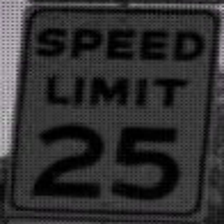

In [11]:
display(image.crop(bb).resize((224,224)))

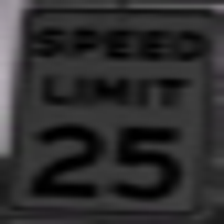

In [21]:
tmp1 = tmp.crop(bb_test)
display(tmp1.resize((224,224)))
#print((all_ann['Upper left corner X'][i],all_ann['Upper left corner Y'][i],all_ann['Lower right corner X'][i],all_ann['Lower right corner Y'][i]))

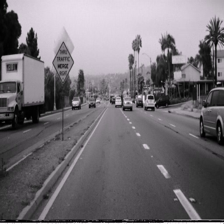

In [20]:
path = "lib/datasets/LISA/"
file = all_ann["Filename"][1000]
sign = all_ann["Annotation tag"][1000]
image = Image.open(path+file)
tmp = image.resize((width,height))
display(tmp)

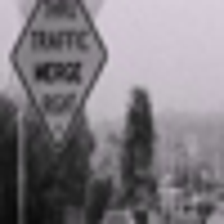

(17, 14, 115, 133)


In [22]:
tmp1 = tmp.crop((50,50,100,100))
display(tmp1.resize((224,224)))
print((all_ann['Upper left corner X'][i],all_ann['Upper left corner Y'][i],all_ann['Lower right corner X'][i],all_ann['Lower right corner Y'][i]))

In [3]:
X_train = np.load("lib/datasets/X_train.npy")
X_test = np.load("lib/datasets/X_test.npy" )
X_val = np.load("lib/datasets/X_val.npy")
y_train_e = np.load("lib/datasets/y_train_e.npy")
y_test_e = np.load("lib/datasets/y_test_e.npy")
y_val_e = np.load("lib/datasets/y_val_e.npy" )

In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, ZeroPadding2D, BatchNormalization

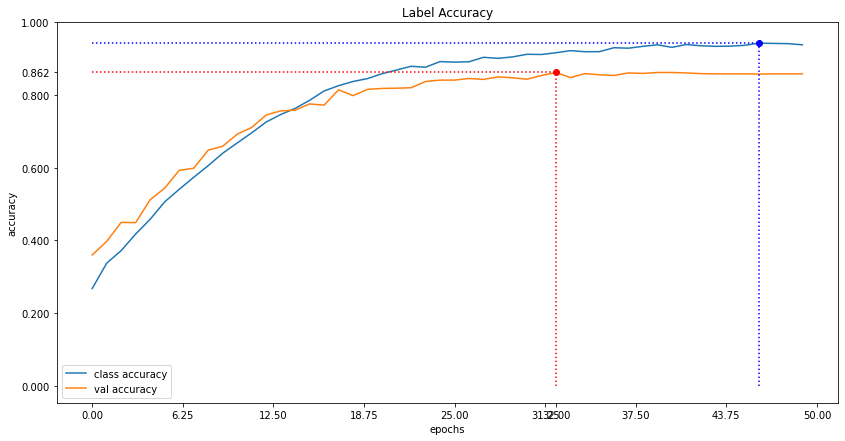

In [5]:
from lib.Plot import plot
plot(history)

In [6]:
model=Sequential()

model.add(Conv2D(96,(11,11),strides=4,activation='relu',input_shape=X_train.shape[1:],padding='valid'))
model.add(MaxPool2D((3,3),strides=2))
model.add(BatchNormalization())

model.add(ZeroPadding2D(padding=2))
model.add(Conv2D(256,(5,5),activation='relu',padding='same'))
model.add(MaxPool2D((3,3), strides=2))
model.add(BatchNormalization())

model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(384,(3,3),activation='relu',padding='same'))

model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(384,(3,3),activation='relu',padding='same'))

model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(256,(3,3),activation='relu',padding='same'))

model.add(Flatten())
model.add(Dense(4096,activation="relu"))
model.add(Dropout(rate=0.5))
model.add(Dense(4096,activation="relu"))
model.add(Dropout(rate=0.5))
model.add(Dense(48,activation="softmax"))

model.compile(loss='sparse_categorical_crossentropy',optimizer=tf.optimizers.SGD(learning_rate=0.001),
              metrics=['accuracy'])
#callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5, verbose=1,
    mode='max', min_delta=0.0001, cooldown=2, min_lr=0)
epochs = 50
history = model.fit(X_train, y_train_e, batch_size=32, epochs=epochs,
validation_data=(X_val, y_val_e), callbacks = [callback])

Epoch 1/50
148/148 [==============================] - 25s 126ms/step - loss: 2.8397 - accuracy: 0.2671 - val_loss: 2.4362 - val_accuracy: 0.3711 - lr: 0.0010
Epoch 2/50
148/148 [==============================] - 12s 82ms/step - loss: 2.4862 - accuracy: 0.3329 - val_loss: 2.2225 - val_accuracy: 0.3959 - lr: 0.0010
Epoch 3/50
148/148 [==============================] - 13s 85ms/step - loss: 2.3190 - accuracy: 0.3753 - val_loss: 2.0645 - val_accuracy: 0.4297 - lr: 0.0010
Epoch 4/50
148/148 [==============================] - 12s 83ms/step - loss: 2.1540 - accuracy: 0.4080 - val_loss: 1.9485 - val_accuracy: 0.4857 - lr: 0.0010
Epoch 5/50
148/148 [==============================] - 12s 83ms/step - loss: 1.9767 - accuracy: 0.4553 - val_loss: 1.7473 - val_accuracy: 0.5277 - lr: 0.0010
Epoch 6/50
148/148 [==============================] - 13s 91ms/step - loss: 1.8620 - accuracy: 0.4829 - val_loss: 1.6347 - val_accuracy: 0.5493 - lr: 0.0010
Epoch 7/50
148/148 [==============================] - 13s

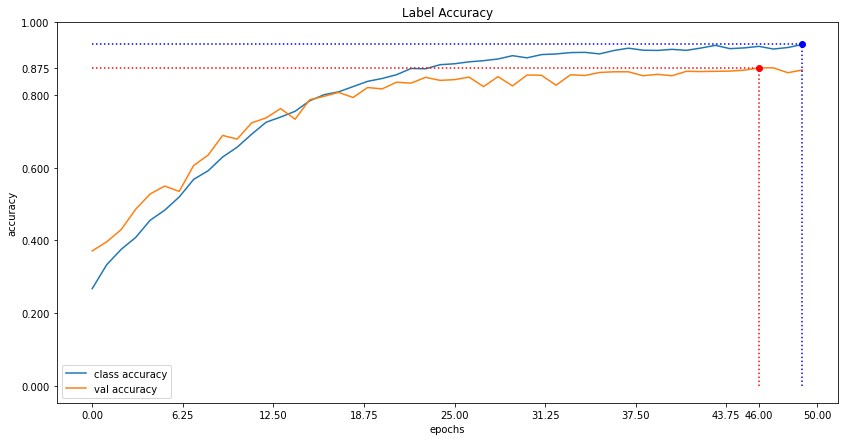

In [7]:
from lib.Plot import plot
plot(history)

In [26]:
i=500
height = 150
width = 150
path = "lib/datasets/LISA/"
file = all_ann["Filename"][i]
sign = all_ann["Annotation tag"][i]

image = Image.open(path+file)
tmp = image.resize((width,height))
image.show()
tmp = np.asarray(tmp).astype('float64')
tmp /= 225
tmp = tmp.reshape((1,width,height,3))
boxes = alex_b.predict(tmp)
print((boxes[0][0]*18*150,boxes[0][1]*18*150,boxes[0][2]*18*150,boxes[0][3]*150*18))
print((all_ann['Upper left corner X'][i],all_ann['Upper left corner Y'][i],all_ann['Lower right corner X'][i],all_ann['Lower right corner Y'][i]))
image = image.crop((boxes[0][0]*18*150,boxes[0][1]*18*150,boxes[0][2]*18*150,boxes[0][3]*150*18))
# image = image.resize((224,224))
image.show()

(927.5557816028595, 226.24202370643616, 1134.3557864427567, 411.8464082479477)
(17, 14, 115, 133)


In [4]:
#max image size
height = 150
width = 150
data = []
labels = []
targets=[]
path = "lib/datasets/LISA/"
test = 0
import random
count = 0

sub_sample = np.load("lib/datasets/sample.npy")  # The data set is too big for my PC
print(len(sub_sample))
for i in sub_sample:
    if count % 1000 == 0:
        print(count)
    count+=1
    file = all_ann["Filename"][i]
    sign = all_ann["Annotation tag"][i]
    
    image = Image.open(path+file)
    tmp = image.resize((width,height))
    
    tmp = np.asarray(tmp).astype('float64')
    tmp /= 225
    tmp = tmp.reshape((1,width,height,3))
    boxes = alex_b.predict(tmp)
    image = image.crop((boxes[0][0],boxes[0][1],boxes[0][2],boxes[0][3]))
    image = image.resize((224,224))
    image = np.asarray(image).astype('float64')
    
    data.append(image)
    labels.append(sign)
    #targets.append((all_ann['Upper left corner X'][i],all_ann['Upper left corner Y'][i],all_ann['Lower right corner X'],all_ann['Lower right corner Y']))


signs = np.array(data)
labels = np.array(labels)

# Randomize order
s = np.arange(signs.shape[0])
np.random.seed(43)
np.random.shuffle(s)
signs = signs[s]
labels = labels[s]

6855
0
1000
2000
3000
4000
5000
6000


In [6]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
X_train, X_val, y_train, y_val = train_test_split(signs, labels, test_size=0.25, random_state=1)
del signs
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
# Preprocess
X_train = X_train.astype('float64')
X_val = X_val.astype('float64')
#X_val = X_test.astype('float64')

mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val -= mean_image
#X_test -= mean_image
def one_hot(lab, vals):
    hot = []
    for i in range(len(vals)):
        hot.append(lab.tolist().index(vals[i]))
    return hot

lab = np.unique(labels)
y_train_e = np.array(one_hot(lab, y_train))
y_val_e = np.array(one_hot(lab, y_val))
#y_test_e = np.array(one_hot(lab, y_test))

tmp = pd.DataFrame()
tmp["Label"] = lab
tmp["Encoding"] = list(range(len(lab)))
tmp.to_csv("lib/datasets/key1.csv", index=False)
np.save("lib/datasets/X_train1.npy", X_train)
np.save("lib/datasets/X_val1.npy", X_val)
np.save("lib/datasets/y_train1.npy", y_train_e)
np.save("lib/datasets/y_val1.npy", y_val_e)


In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import tensorflow as tf

In [2]:
X_train = np.load("lib/datasets/X_train1.npy")
X_val = np.load("lib/datasets/X_val1.npy")
y_train_e = np.load("lib/datasets/y_train1.npy")
y_val_e = np.load("lib/datasets/y_val1.npy" )

In [7]:
tmp = X_train[5]
from matplotlib import pyplot as plt
img = Image.fromarray(tmp, 'RGB')
img.show()

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, ZeroPadding2D, BatchNormalization

In [4]:
model=Sequential()

model.add(Conv2D(96,(11,11),strides=4,activation='relu',input_shape=X_train.shape[1:],padding='valid'))
model.add(MaxPool2D((3,3),strides=2))
model.add(BatchNormalization())

model.add(ZeroPadding2D(padding=2))
model.add(Conv2D(256,(5,5),activation='relu',padding='same'))
model.add(MaxPool2D((3,3), strides=2))
model.add(BatchNormalization())

model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(384,(3,3),activation='relu',padding='same'))

model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(384,(3,3),activation='relu',padding='same'))

model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(256,(3,3),activation='relu',padding='same'))

model.add(Flatten())
model.add(Dense(4096,activation="relu"))
model.add(Dropout(rate=0.5))
model.add(Dense(4096,activation="relu"))
model.add(Dropout(rate=0.5))
model.add(Dense(47,activation="softmax"))

model.compile(loss='sparse_categorical_crossentropy',optimizer=tf.optimizers.SGD(learning_rate=0.001),
              metrics=['accuracy'])
#callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5, verbose=1,
    mode='max', min_delta=0.0001, cooldown=2, min_lr=0)
epochs = 50
history = model.fit(X_train, y_train_e, batch_size=32, epochs=epochs,
validation_data=(X_val, y_val_e), callbacks = [callback])

Epoch 1/50
161/161 [==============================] - 22s 106ms/step - loss: 3.8438 - accuracy: 0.2260 - val_loss: 3.8373 - val_accuracy: 0.2357 - lr: 0.0010
Epoch 2/50
161/161 [==============================] - 13s 79ms/step - loss: 3.8309 - accuracy: 0.2276 - val_loss: 3.8245 - val_accuracy: 0.2357 - lr: 0.0010
Epoch 3/50
161/161 [==============================] - 13s 79ms/step - loss: 3.8182 - accuracy: 0.2276 - val_loss: 3.8118 - val_accuracy: 0.2357 - lr: 0.0010
Epoch 4/50
161/161 [==============================] - 13s 79ms/step - loss: 3.8055 - accuracy: 0.2276 - val_loss: 3.7992 - val_accuracy: 0.2357 - lr: 0.0010
Epoch 5/50
161/161 [==============================] - 13s 80ms/step - loss: 3.7930 - accuracy: 0.2276 - val_loss: 3.7867 - val_accuracy: 0.2357 - lr: 0.0010
Epoch 6/50
161/161 [==============================] - ETA: 0s - loss: 3.7805 - accuracy: 0.2276
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
161/161 [==============================] 

KeyboardInterrupt: 